# Лабораторная работа

**Сверточные нейронные сети**



## Загрузка данных

В данной работе будет использоваться учебный датасет с изображениями персонажей из Симпсонов. Загрузите файлы и распакуйте, вo вкладке Files должна появиться папка `data`, а в ней папки `train` и `test`.

In [1]:
%%time


! unzip -o -q rgb-test.zip -d data

! unzip -o -q rgb-train.zip -d data

"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


CPU times: total: 0 ns
Wall time: 121 ms


"unzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


## Создание объекта Dataset

Так как изображения в датасете организованы по папкам, где имя папки является ярлыком для данных, то мы можем воспользоваться базовым классом `ImageFolder`.

Одним из параметров является `transform`, для которого необходимо скомпоновать преобразования для наших изображений. В pytorch для преобразований есть два набора функций V1 и V2 и рекомендуется использовать V2.

Для компоновки функции из модуля v2 используйте `Compose`.Параметры:
* ToImage() - преобразование в `Image` (подкласс torch.Tensor)
* RandomVerticalFlip() - случайное отзеркаливание
* ToDtype(torch.float32, scale=True) - преобразование из int во float
* Normalize() - нормализация изображений по полученным средним и стандартным отклонениям.

По желанию:
* RandomRotation() - поворот на случайный угол в указанном диапазоне
* Можете попробовать и другие варианты преобразований. [Документация API V2](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

 При обучении используете весь набор обязательных преобразований, при проверке требуется только преобразовать изображение к тензору с плавающей точкой и провести нормализацию.

### Получение статистик для нормализации

In [1]:
import torch
from torchvision.transforms import v2

transforms_stats = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [2]:
from torchvision.datasets import ImageFolder

stats_dataset = ImageFolder(root="C:/Users/chvas/Downloads/rgb-train (1)/train", transform=transforms_stats)

In [3]:
imgs = [item[0] for item in stats_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")

Means R, G, B: (0.46527502, 0.4091916, 0.35515454)
Std R, G, B: (0.25361815, 0.23093477, 0.2540287)



Используйте выведенные выше значения средних и стандартных отклонений в качестве аргументов функции `Normalize`.

In [5]:
transforms_train = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.46527502, 0.4091916, 0.35515454], std=[0.25361815, 0.23093477, 0.2540287])
])

transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.46527502, 0.4091916, 0.35515454], std=[0.25361815, 0.23093477, 0.2540287])
])

Теперь, когда есть необходимые `transforms` можно создать ImageFolder, указав в `root` путь до выборки и `transforms` в `transform`.

In [7]:
train_dataset = ImageFolder(
    root="C:/Users/chvas/Downloads/rgb-train (1)/train", 
    transform=transforms_train
)

test_dataset = ImageFolder(
    root="C:/Users/chvas/Downloads/rgb-test (1)/test", 
    transform=transforms_test
)

In [8]:
print(f"Количество изображений в обучающей выборке: {len(train_dataset)}")
print(f"Количество изображений в проверочной выборке: {len(test_dataset)}")

print(f"Количество классов: {len(train_dataset.classes)}")
print(f"Классы: {train_dataset.classes}")

Количество изображений в обучающей выборке: 8000
Количество изображений в проверочной выборке: 2000
Количество классов: 10
Классы: ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


## Создание DataLoader

Далее необходимо подготовить три загрузчика данных:

1. Обучающий
2. Проверочный
3. Тестовый

Тестовый загрузчик делается из тестового Dataset, а обучающий и проверочный необходимо создать, используя [SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler), для его работы требуется массив индексов, по которым в дальнейшем загрузчик будет в случайном порядке брать изображения и лейблы.

In [10]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

val_size = 0.2

train_samples = len(train_dataset)
train_indices = list(range(train_samples))

split_value = int(np.floor(val_size * train_samples))
np.random.shuffle(train_indices)

train_idx, val_idx = train_indices[split_value:], train_indices[:split_value]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler
)

val_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

## Создание модели


Сохдайте модель сети.
Сверточные нейронные сети состоят из двух частей:
1. Слои свертки(функции свертки, активации, субдискретизации)
2. Полносвязные слои (MLP)

Слои можно объединить с помощью `nn.Sequential()`. А класс модели должен наследоваться от `nn.Module`.

`def forward()` определяет прямой ход и должна возвращать итоговый результат работы модели - в данном случае логиты.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        out = out.view(out.size(0), -1)  

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

## Создание объекта модели, функции потерь и оптимизатора

В качестве функции потерь будет использована перекрестная энтропия.

В качестве оптимизатора можете взять стохастический градиентный спуск или Adam.

In [16]:
num_classes = 10
num_epochs = 10   
learning_rate = 0.005  

model = ConvNet(num_classes)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),  
    lr=learning_rate,   
    momentum=0.9  
)

## Цикл обучения

Попробуйте разные гиперпараметры для вашей модели. Попробуйте улучшить результат от первой попытки.

Можно вывести графики потерь и точности от эпохи.

In [18]:
%%time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 2.1923
Validation Accuracy: 32.38%
Epoch [2/10], Loss: 1.7126
Validation Accuracy: 49.50%
Epoch [3/10], Loss: 1.4142
Validation Accuracy: 56.81%
Epoch [4/10], Loss: 1.1776
Validation Accuracy: 61.25%
Epoch [5/10], Loss: 0.9828
Validation Accuracy: 65.56%
Epoch [6/10], Loss: 0.8084
Validation Accuracy: 67.12%
Epoch [7/10], Loss: 0.6694
Validation Accuracy: 69.88%
Epoch [8/10], Loss: 0.5032
Validation Accuracy: 71.25%
Epoch [9/10], Loss: 0.3836
Validation Accuracy: 71.94%
Epoch [10/10], Loss: 0.2721
Validation Accuracy: 73.06%
CPU times: total: 7min 47s
Wall time: 2min 58s


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Итоговая оценка

Часть кода, которую вы реализовали для оценки модели на валидационной выборке, можно использовать для финальной проверки, указав нужный loader.

In [19]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:  
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)  
        correct += (predicted == labels).sum().item()  

    print(f'Точность (accuracy) {100 * correct / total:.2f}%')


Точность (accuracy) 74.05%


#  Задание 1.
1. Загрузите датасет Cifar-10
https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html
2.	Создайте 3 архитектуры сверточной нейронной сети для распознавания данных из набора Cifar-10. Обучите сеть и выведите результаты на тренировочной и валидационной выборках.
4.	Проверьте работу сети на тестовой выборке.
5.	Загрузите файлы с картинками из интернета или создайте свои фотографии.
6.	Проверьте работу сети на собственных картинках.

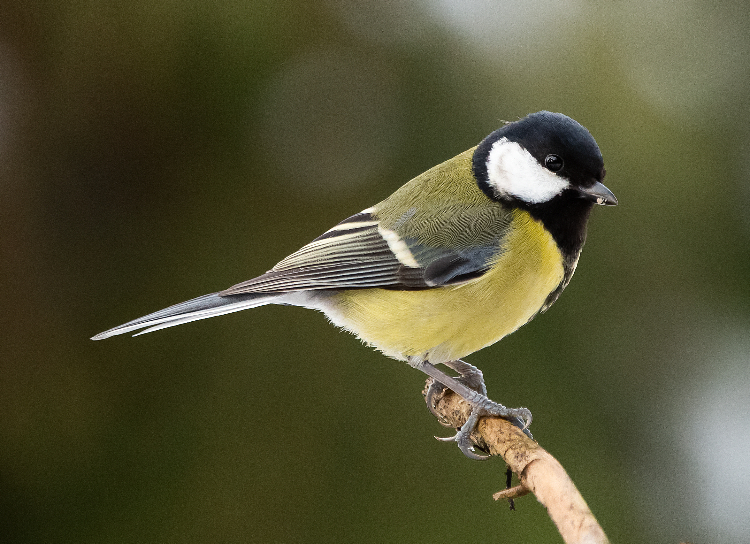


Training model: SimpleConvNet
Epoch 1, Loss: 1.1763, Accuracy: 58.22%
Epoch 2, Loss: 0.7445, Accuracy: 73.92%
Epoch 3, Loss: 0.4595, Accuracy: 84.08%
Accuracy on test data: 71.36%

Training model: ConvNet3Layers
Epoch 1, Loss: 1.1907, Accuracy: 57.21%
Epoch 2, Loss: 0.7370, Accuracy: 74.24%
Epoch 3, Loss: 0.5131, Accuracy: 82.01%
Accuracy on test data: 75.81%

Training model: DeepConvNet
Epoch 1, Loss: 1.3993, Accuracy: 48.86%
Epoch 2, Loss: 0.8766, Accuracy: 69.19%
Epoch 3, Loss: 0.6911, Accuracy: 75.93%
Accuracy on test data: 75.26%


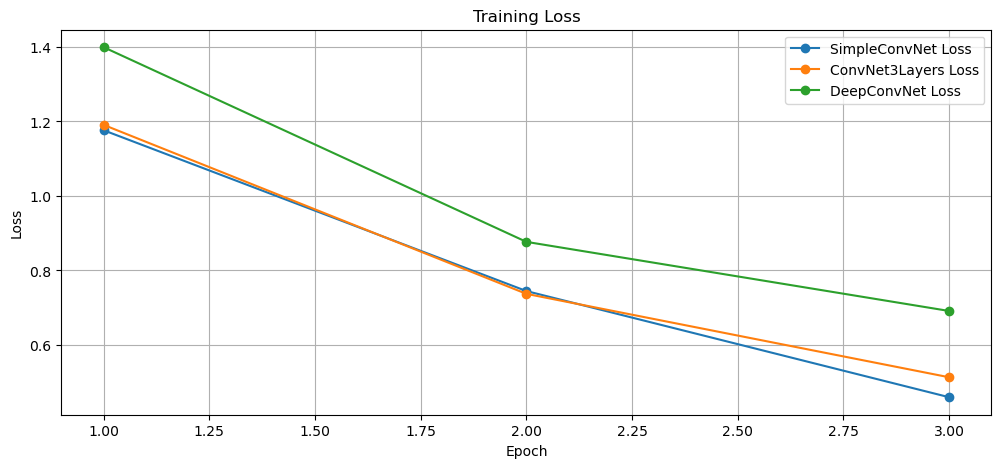

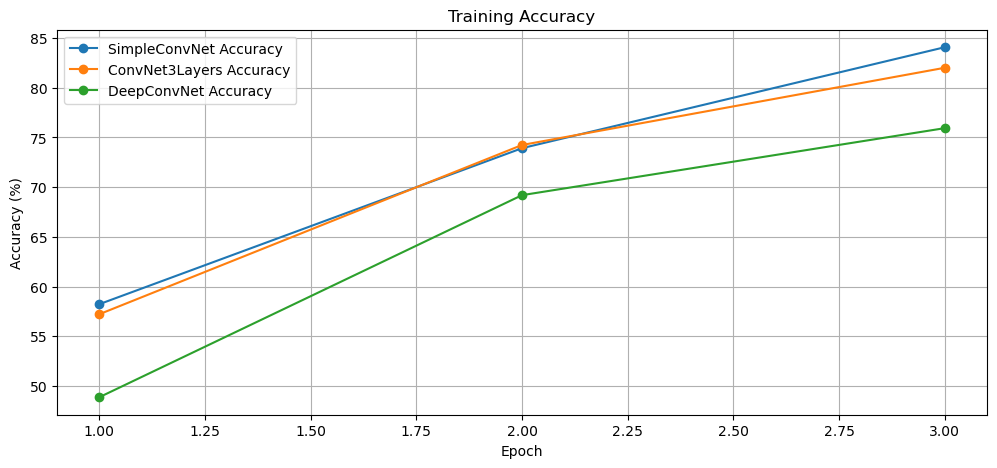

Model SimpleConvNet test accuracy: 71.36%
Model ConvNet3Layers test accuracy: 75.81%
Model DeepConvNet test accuracy: 75.26%

Best model: ConvNet3Layers with test accuracy: 75.81%

Prediction on external image using best model:
Predicted class: bird


In [85]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.fc1 = nn.Linear(64 * 16 * 16, 512)       
        self.fc2 = nn.Linear(512, 10)                 

    def forward(self, x):
        x = F.relu(self.conv1(x))             
        x = F.relu(self.conv2(x))             
        x = F.max_pool2d(x, 2)                
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))             
        x = self.fc2(x)                      
        return x


class ConvNet3Layers(nn.Module):
    def __init__(self):
        super(ConvNet3Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)    
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 8 * 8, 512)         
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))                
        x = F.relu(self.conv2(x))                
        x = F.max_pool2d(x, 2)                  
        x = F.relu(self.conv3(x))          
        x = F.max_pool2d(x, 2)                 
        x = x.view(x.size(0), -1)             
        x = F.relu(self.fc1(x))                  
        x = self.fc2(x)                        
        return x


class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)     
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)    
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)   
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)   
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)          
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))                     
        x = F.relu(self.conv2(x))                      
        x = F.max_pool2d(x, 2)                          
        x = F.relu(self.conv3(x))                       
        x = F.max_pool2d(x, 2)                         
        x = F.relu(self.conv4(x))                     
        x = F.max_pool2d(x, 2)                         
        x = x.view(x.size(0), -1)                      
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model_with_metrics(model, trainloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_losses, epoch_accuracies

def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f'Accuracy on test data: {test_acc:.2f}%')
    return test_acc

models = [SimpleConvNet(), ConvNet3Layers(), DeepConvNet()]
metrics = {}      
test_accuracies = {}  

num_epochs = 3
learning_rate = 0.001

for model in models:
    model_name = model.__class__.__name__
    print(f"\nTraining model: {model_name}")
    losses, accuracies = train_model_with_metrics(model, trainloader, num_epochs=num_epochs, learning_rate=learning_rate)
    test_acc = test_model(model, testloader)
    metrics[model_name] = (losses, accuracies)
    test_accuracies[model_name] = test_acc

epochs_range = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
for model_name, (losses, _) in metrics.items():
    plt.plot(epochs_range, losses, marker='o', label=f"{model_name} Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
for model_name, (_, accuracies) in metrics.items():
    plt.plot(epochs_range, accuracies, marker='o', label=f"{model_name} Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()
plt.grid(True)
plt.show()

best_model = None
best_accuracy = 0
best_model_name = ""
for model in models:
    model_name = model.__class__.__name__
    acc = test_accuracies[model_name]
    print(f"Model {model_name} test accuracy: {acc:.2f}%")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = model_name

print(f"\nBest model: {best_model_name} with test accuracy: {best_accuracy:.2f}%")

def predict_image(model, image_path=None, image_url=None):
    model.eval()
    img_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if image_url:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    elif image_path:
        img = Image.open(image_path).convert("RGB")
    else:
        raise ValueError("Укажите image_url или image_path")
    
    img_tensor = img_transform(img).unsqueeze(0)  
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output.data, 1)
    classes = trainset.classes
    print("Predicted class:", classes[predicted.item()])

sample_image_url = "https://na-zapade-mos.ru/files/data/user/AiF/olga.k/files/2020/2022.03.21-1647874679.8509_bolshaja-sinica.jpg"
print("\nPrediction on external image using best model:")
predict_image(best_model, image_url=sample_image_url)

#  Задание 2.
1. Загрузите датасет Cifar-100
https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR100.html
2.	Создайте 3 архитектуры сверточной нейронной сети для распознавания данных из набора Cifar-10. Обучите сеть и выведите результаты на тренировочной и валидационной выборках.
4.	Проверьте работу сети на тестовой выборке.
5.	Загрузите файлы с картинками из интернета или создайте свои фотографии.
6.	Проверьте работу сети на собственных картинках.

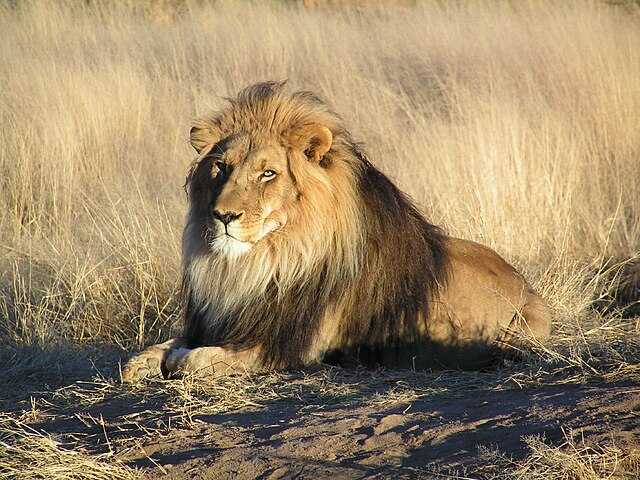

100%|███████████████████████████████████████████████████████████████████████████████| 169M/169M [00:19<00:00, 8.71MB/s]



Training model: SimpleConvNet
Epoch 1, Loss: 3.1971, Accuracy: 22.98%
Epoch 2, Loss: 2.1771, Accuracy: 43.29%
Epoch 3, Loss: 1.4294, Accuracy: 60.38%
Test Accuracy: 38.74%

Training model: ConvNet3Layers
Epoch 1, Loss: 3.4347, Accuracy: 18.25%
Epoch 2, Loss: 2.5031, Accuracy: 35.81%
Epoch 3, Loss: 2.0472, Accuracy: 45.34%
Test Accuracy: 41.77%

Training model: DeepConvNet
Epoch 1, Loss: 3.8538, Accuracy: 10.87%
Epoch 2, Loss: 3.0974, Accuracy: 23.83%
Epoch 3, Loss: 2.7297, Accuracy: 30.99%
Test Accuracy: 34.19%


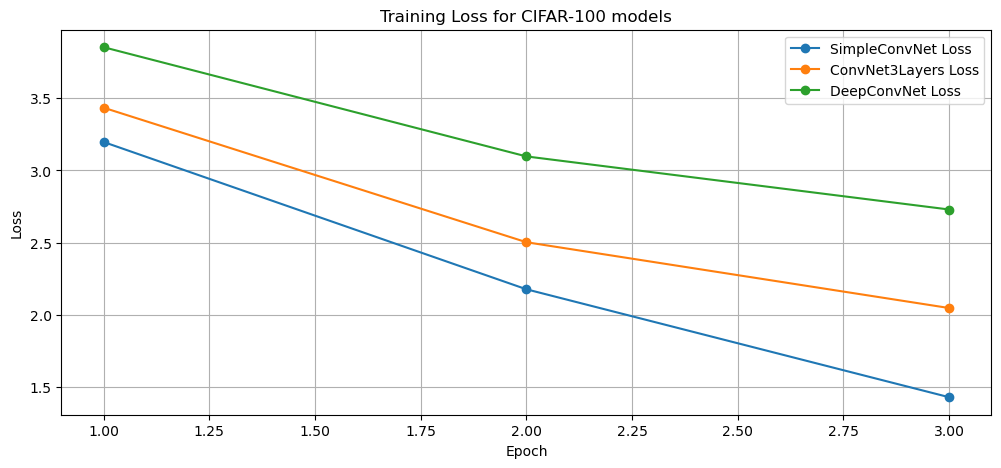

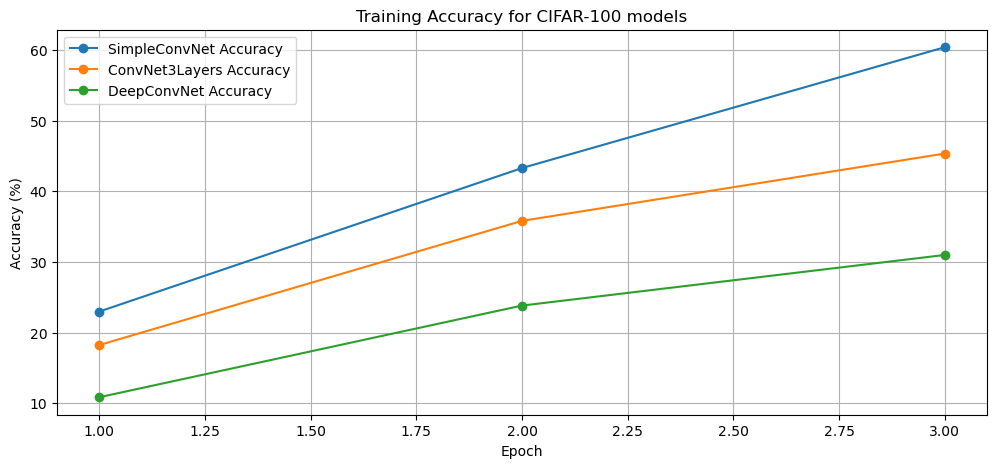

Model SimpleConvNet test accuracy: 38.74%
Model ConvNet3Layers test accuracy: 41.77%
Model DeepConvNet test accuracy: 34.19%

Best model: ConvNet3Layers with test accuracy: 41.77%

Prediction on external image using best model:
Predicted class: lion


C:\Users\chvas\anaconda3\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [88]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   
        self.fc1 = nn.Linear(64 * 16 * 16, 512)        
        self.fc2 = nn.Linear(512, 100)          

    def forward(self, x):
        x = F.relu(self.conv1(x))      
        x = F.relu(self.conv2(x))     
        x = F.max_pool2d(x, 2)          
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))         
        x = self.fc2(x)                 
        return x


class ConvNet3Layers(nn.Module):
    def __init__(self):
        super(ConvNet3Layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)    
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 8 * 8, 512)         
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = F.relu(self.conv2(x))        
        x = F.max_pool2d(x, 2)            
        x = F.relu(self.conv3(x))        
        x = F.max_pool2d(x, 2)           
        x = x.view(x.size(0), -1)         
        x = F.relu(self.fc1(x))           
        x = self.fc2(x)                  
        return x

class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)     
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)   
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)  
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)  
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)          
        self.fc2 = nn.Linear(1024, 100)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))        
        x = F.relu(self.conv2(x))        
        x = F.max_pool2d(x, 2)           
        x = F.relu(self.conv3(x))         
        x = F.max_pool2d(x, 2)           
        x = F.relu(self.conv4(x))       
        x = F.max_pool2d(x, 2)           
        x = x.view(x.size(0), -1)        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                 
        return x

def train_model_with_metrics(model, trainloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / len(trainloader)
        accuracy = 100 * correct / total
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return epoch_losses, epoch_accuracies

def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc


models = [SimpleConvNet(), ConvNet3Layers(), DeepConvNet()]
metrics = {}        
test_accuracies = {} 
num_epochs = 3
learning_rate = 0.001

for model in models:
    model_name = model.__class__.__name__
    print(f"\nTraining model: {model_name}")
    losses, accuracies = train_model_with_metrics(model, trainloader, num_epochs=num_epochs, learning_rate=learning_rate)
    test_acc = test_model(model, testloader)
    metrics[model_name] = (losses, accuracies)
    test_accuracies[model_name] = test_acc

epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
for model_name, (losses, _) in metrics.items():
    plt.plot(epochs_range, losses, marker='o', label=f"{model_name} Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for CIFAR-100 models")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for model_name, (_, accuracies) in metrics.items():
    plt.plot(epochs_range, accuracies, marker='o', label=f"{model_name} Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy for CIFAR-100 models")
plt.legend()
plt.grid(True)
plt.show()

best_model = None
best_accuracy = 0
best_model_name = ""
for model in models:
    model_name = model.__class__.__name__
    acc = test_accuracies[model_name]
    print(f"Model {model_name} test accuracy: {acc:.2f}%")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model
        best_model_name = model_name

print(f"\nBest model: {best_model_name} with test accuracy: {best_accuracy:.2f}%")

def predict_image(model, image_path=None, image_url=None):
    model.eval()
    img_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if image_url:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    elif image_path:
        img = Image.open(image_path).convert("RGB")
    else:
        raise ValueError("Укажите image_url или image_path")
    
    img_tensor = img_transform(img).unsqueeze(0)
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output.data, 1)
    classes = trainset.classes  
    print("Predicted class:", classes[predicted.item()])

sample_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/7/73/Lion_waiting_in_Namibia.jpg/640px-Lion_waiting_in_Namibia.jpg"
print("\nPrediction on external image using best model:")
predict_image(best_model, image_url=sample_image_url)